In [8]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import gdown
!gdown https://drive.google.com/uc?id=1MkWKthet1Avnr4NvPifTMjUc3-3vrj39
!unzip GANFormer.zip
!rm GANFormer.zip

Downloading...
From: https://drive.google.com/uc?id=1MkWKthet1Avnr4NvPifTMjUc3-3vrj39
To: /content/GANFormer/GANFormer.zip
100% 656k/656k [00:00<00:00, 42.0MB/s]
Archive:  GANFormer.zip
   creating: GANFormer/
  inflating: __MACOSX/._GANFormer    
   creating: GANFormer/metrics/
  inflating: __MACOSX/GANFormer/._metrics  
  inflating: GANFormer/dataset_tool.py  
  inflating: __MACOSX/GANFormer/._dataset_tool.py  
  inflating: GANFormer/run_metrics.py  
  inflating: __MACOSX/GANFormer/._run_metrics.py  
  inflating: GANFormer/.DS_Store     
  inflating: __MACOSX/GANFormer/._.DS_Store  
  inflating: GANFormer/Dockerfile    
  inflating: __MACOSX/GANFormer/._Dockerfile  
  inflating: GANFormer/pretrained_networks.py  
  inflating: __MACOSX/GANFormer/._pretrained_networks.py  
   creating: GANFormer/training/
  inflating: __MACOSX/GANFormer/._training  
  inflating: GANFormer/test_nvcc.cu  
  inflating: __MACOSX/GANFormer/._test_nvcc.cu  
   creating: GANFormer/docs/
  inflating: __MACOSX/

In [10]:
%cd /content/GANFormer

/content/GANFormer


In [11]:
!pip install tensorflow-gpu==1.15.3

In [12]:
%tensorflow_version 1.x
import tensorflow as tf

%matplotlib inline 
from matplotlib import pyplot as plt

# Download the model of choice
import argparse
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import re
import sys
from io import BytesIO
import IPython.display
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
import imageio

# Useful utility functions...
import cv2
import pretrained_networks

# network_pkl = "/content/drive/MyDrive/gansformer-reproducibility-challenge/GANFormer-network-snapshot-000300.pkl"
# network_type = "ganformer"

network_pkl = "/content/drive/MyDrive/gansformer-reproducibility-challenge/network-final-2.pkl"
network_type = "stylegan2"

print('Loading networks from "%s"...' % network_pkl)
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

Loading networks from "/content/drive/MyDrive/gansformer-reproducibility-challenge/network-final-2.pkl"...


In [34]:
# Generates a list of images, based on a list of latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_in_w_space(dlatents, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    Gs_kwargs.truncation_psi = truncation_psi
    dlatent_avg = Gs.get_var('dlatent_avg') # [component]

    imgs = []
    for row, dlatent in log_progress(enumerate(dlatents), name = "Generating images"):
        #row_dlatents = (dlatent[np.newaxis] - dlatent_avg) * np.reshape(truncation_psi, [-1, 1, 1]) + dlatent_avg
        dl = (dlatent-dlatent_avg)*truncation_psi   + dlatent_avg
        row_images = Gs.components.synthesis.run(dlatent,  **Gs_kwargs)
        imgs.append(PIL.Image.fromarray(row_images[0], 'RGB'))
    return imgs       

def generate_images(zs, truncation_psi, network_type):
    Gs_kwargs = dnnlib.EasyDict()
    # Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    
    for z_idx, z in log_progress(enumerate(zs), size = len(zs), name = "Generating images"):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]

        if network_type == 'ganformer':
          res_images = np.transpose((images[0][0, :, :, :]), (1, 2, 0))

        elif network_type == 'stylegan2': 
          res_images = np.transpose(images[0], (1, 2, 0))

        else:
          raise ValueError('Invalid network_type')

        res_images = (res_images - np.min(res_images))/np.ptp(res_images)
        imgs.append(res_images)

    return imgs

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

# Generates a list of images, based on a list of seed for latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_from_seeds(seeds, truncation_psi, network_type):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi, network_type)

def saveImgs(imgs, location):
  for idx, img in log_progress(enumerate(imgs), size = len(imgs), name="Saving images"):
    file = location+ str(idx) + ".png"
    img.save(file)

def imshow(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  str_file = BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

        
def clamp(x, minimum, maximum):
    return max(minimum, min(x, maximum))
    
def drawLatent(image,latents,x,y,x2,y2, color=(255,0,0,100)):
  buffer = PIL.Image.new('RGBA', image.size, (0,0,0,0))
   
  draw = ImageDraw.Draw(buffer)
  cy = (y+y2)/2
  draw.rectangle([x,y,x2,y2],fill=(255,255,255,180), outline=(0,0,0,180))
  for i in range(len(latents)):
    mx = x + (x2-x)*(float(i)/len(latents))
    h = (y2-y)*latents[i]*0.1
    h = clamp(h,cy-y2,y2-cy)
    draw.line((mx,cy,mx,cy+h),fill=color)
  return PIL.Image.alpha_composite(image,buffer)

def convertZtoW(latent, truncation_psi=0.7, truncation_cutoff=9):
  dlatent = Gs.components.mapping.run(latent, None) # [seed, layer, component]
  dlatent_avg = Gs.get_var('dlatent_avg') # [component]
  for i in range(truncation_cutoff):
    dlatent[0][i] = (dlatent[0][i]-dlatent_avg)*truncation_psi + dlatent_avg
    
  return dlatent

def interpolate(zs, steps):
   out = []
   for i in range(len(zs)-1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
   return out

# Taken from https://github.com/alexanderkuk/log-progress
def log_progress(sequence, every=1, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )


[9930950  147393 7186335]


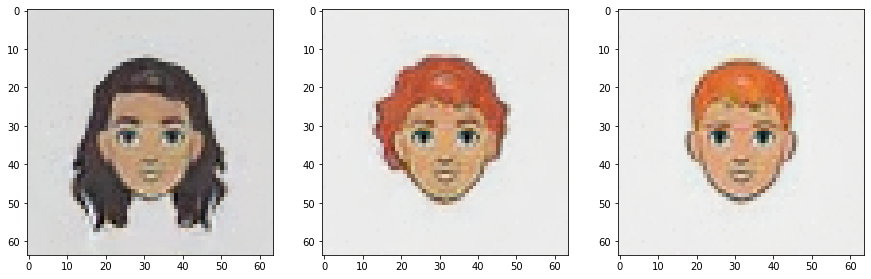

In [35]:
# generate some random seeds
seeds = np.random.randint(10000000, size=3)
print(seeds)

# show the seeds
out = generate_images_from_seeds(seeds, 0.7, network_type)

fig, ax = plt.subplots(1, len(seeds), figsize=(15, 15*len(seeds)))
for l_idx, l in enumerate(out):
  ax[l_idx].imshow(l)

plt.show()

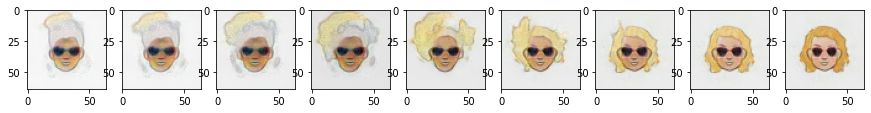

In [36]:
# Simple (Z) interpolation
zs = generate_zs_from_seeds([5015289, 9148088])

latent1 = zs[0]
latent2 = zs[1]

number_of_steps = 9

imgs = generate_images(interpolate([latent1,latent2],number_of_steps), 1.0, network_type)

fig, ax = plt.subplots(1, len(imgs), figsize=(15,15*len(imgs)))
for l_idx, l in enumerate(imgs):
  ax[l_idx].imshow(l)

plt.show()

In [37]:
# generating a MP4 movie

zs = generate_zs_from_seeds([421645,6149575,3487643,3766864 ,3857159,5360657,3720613])

number_of_steps = 10
imgs = generate_images(interpolate(zs,number_of_steps), 1.0, network_type)

# Example of reading a generated set of images, and storing as MP4.
%mkdir out
movieName = 'out/mov.mp4'

with imageio.get_writer(movieName, mode='I') as writer:
    for image in log_progress(list(imgs), name = "Creating animation"):
        writer.append_data(np.array(image))

mkdir: cannot create directory ‘out’: File exists


In [ ]:
# In order to download files, you can use the snippet below - this often fails for me, though, so I prefer the 'Files' browser in the sidepanel.

from google.colab import files
files.download(movieName) 
